In [1]:
# %cd ~/src/Sunrise-Demo/
from __future__ import annotations
try:
    from mediocreatbest import auto, run
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
from mediocreatbest import auto, run

In [18]:
SPECIES = "0000143"
TIXEL_Z = 21
ZOOM_RESOLUTION = 5
SHELVE_PATH = auto.pathlib.Path.cwd() / 'background-shelve' / 'Sunrise.shelve'

## Setup

In [4]:
%%scope
def string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(string_function, repr=False)
auto.numpy.set_string_function(string_function, repr=True)

auto.numpy.set_printoptions(
    threshold=4,
    edgeitems=0,
)

### Typing

In [5]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

## Location (lat, lng, alt) to spatial (x, y, z)

In [6]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

In [7]:
@auto.mediocreatbest.doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    # r"""

    # >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    # 'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    # """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0

    print("LATLNG")
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [8]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.y,
            y=self.x,
            # z=self.z,
            # x=self.x,
            # y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.y,
            y=1+self.x,
            # z=self.z,
            # x=1+self.x,
            # y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

In [9]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

In [10]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

In [11]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [12]:
# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    # z: ClassVar[int] = 23
    z: ClassVar[int] = TIXEL_Z
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    

In [13]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @auto.mediocreatbest.doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

## HTTP Request Caching

In [14]:
@run(once=True)
def cache():
    path = SHELVE_PATH
    # path = auto.pathlib.Path.cwd() / 'background' / 'Sunrise.shelve'
    return auto.shelve.open(str(path), 'c')

In [15]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            # with auto.requests.get(url) as r:
            #     r.raise_for_status()
            #     cache[key] = r.content
            try:
                r = auto.requests.get(url)
                r.raise_for_status()
                content = r.content
            except auto.requests.exceptions.HTTPError:
                content = 404
            
            cache[key] = content
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
            
            content = cache[key]
        
        if isinstance(content, int):
            # raise auto.requests.exceptions.HTTPError(content)
            return None
        
        return content

    return fetch

In [16]:
def __stitch_tiles(tiles, /, size: int=128, flip=False):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = size
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        # composite.paste(image, (yi*sz, xi*sz))
        if flip==True:
            composite.paste(image, (yi*sz, xi*sz))
        else:
            composite.paste(image, (xi*sz, yi*sz))
            
    
    return composite

In [17]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col

## Background

In [19]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    images = ''
    template = '<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{x}/{y}" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: translate3d(439px, -19px, 0px); opacity: 1;">'
    zoom = ZOOM_RESOLUTION
    # for x in range((2 ** zoom)-1):
    #     for y in range((2 ** zoom)-10):
    #         imgurl = template.format(z = zoom, x = x, y = y)
    #         images = images + imgurl
    #         print(imgurl)
    # soup = BeautifulSoup(images, 'html.parser')
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)

    return Domain(
        lo=Coord(z=11, x=546-1, y=805-1),
        hi=Coord(z=11, x=551+1, y=808+1),
    )
    
    # return Domain(
    #     lo=Coord(
    #         z=min(url.z for url in urls),
    #         x=min(url.x for url in urls),
    #         y=min(url.y for url in urls),
    #     ),
    #     hi=Coord(
    #         z=max(url.z for url in urls),
    #         x=max(url.x for url in urls),
    #         y=max(url.y for url in urls),
    #     ),
    # )


Domain(lo=Coord(z=11, x=545, y=804), hi=Coord(z=11, x=552, y=809))


In [20]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        # r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
        r"""https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/0/0/0"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            # x=coord.x,
            # y=coord.y,
            x=coord.y,
            y=coord.x,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        # print(f'url: {url}')
        # print(f'coord: {coord.x}, {coord.y}')
        # print(f'url: {url}')
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Miss: https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/11/809/552: 100%|██████████| 48/48 [00:54<00:00,  1.14s/it]

48


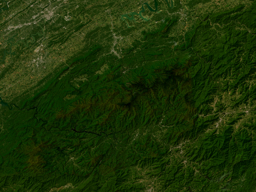

In [21]:
__stitch_tiles(run.g['background__tiles'], size=32)

In [22]:
@run(scope='background')
def interpolator(tiles, /):
    # res = 512
    res = 256
    
    zs = sorted(set(tile.coord.z for tile in tiles))
    assert len(zs) == 1
    ys = sorted(set(tile.coord.y for tile in tiles))
    xs = sorted(set(tile.coord.x for tile in tiles))
    
    print(f"""{len(ys)=!r} {len(xs)=!r}""")
    
    # This is cursed.
    points = (
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(ys)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(xs)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
    )
    
    print(f"""ys: {points[0][[0, -1]]=!r}
xs: {points[1][[0, -1]]=!r}""")
    
    values = auto.numpy.zeros(
        shape=(len(points[0]), len(points[1]), 3),
        dtype=auto.numpy.float32,
    )
    print(f"""{values.shape=!r} {values.dtype=!r}""")

    for tile in tiles:
        yi = ys.index(tile.coord.y)
        xi = xs.index(tile.coord.x)
        
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
            image = auto.PIL.ImageOps.flip(image)
            
        image = image.convert('RGB')
        image = auto.numpy.array(image, dtype=auto.numpy.float32)
        image = image[::-1,:,:]
        assert image.shape == (res, res, 3), image.shape
        assert image.dtype == auto.numpy.float32
        assert 1.0 < image.max() <= 255.0
        
        image /= 255.0
        assert 0.0 < image.max() <= 1.0
        
#         import numpy.lib.recfunctions
#         image = auto.numpy.lib.recfunctions.unstructured_to_structured(
#             image,
#             dtype=values.dtype,
#         )
#         assert image.shape == (res, res), \
#             f"""Wrong shape: {image.shape=!r}"""
#         assert image.dtype == values.dtype
        
        values[
            slice(
                (yi+0)*res,
                (yi+1)*res,
            ),
            slice(
                (xi+0)*res,
                (xi+1)*res,
            ),
        ] = image
               
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points,
        values,
        bounds_error=False,
        fill_value=0,
    )

len(ys)=6 len(xs)=8
ys: points[0][[0, -1]]=ndarray(array([823296., 829436.]), shape=(2,), dtype=dtype('float64'))
xs: points[1][[0, -1]]=ndarray(array([558080., 566268.]), shape=(2,), dtype=dtype('float64'))
values.shape=(1536, 2048, 3) values.dtype=dtype('float32')


In [24]:
@run
def __save(background__interpolator, /):
    def save(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
    ):
        # path = auto.pathlib.Path.cwd() / 'temp' / f'park-{name}.npz'
        path = SHELVE_PATH
        auto.numpy.savez_compressed(
            path,
            points0=interpolator.grid[0],
            points1=interpolator.grid[1],
            values=interpolator.values,
        )
        
        print(f'Wrote {path.stat().st_size :,d} bytes to {path}')
    
    save(
        name='background',
        interpolator=background__interpolator,
    )


Wrote 937,984 bytes to /home/raustin9/src/Sunrise-Demo-Dev/background-shelve/Sunrise.shelve
